# Laboratorium 3

### Konfiguracja

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js
from heapq import *

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.added_points.append(PointsCollection())
         
    def add_line(self, event):
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.added_lines.append(LinesCollection())

    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [8]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points = [], **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines = [], **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self, callback):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(callback.add_line)
        return [b_prev, b_next, b_add_point, b_add_line]
    
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes
        
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])
    
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons(self.callback)
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        


### Przykłady użycia

##### Proste rysowanie

Należy utworzyć zmienną z obiuektem `Plot`, który przyjmuje jako parametr konstruktora listę scen lub string ze scenami w formacie json. Następnie po dodaniu wszystkich, na samym końcu programu, należy wywołać jego metodę `draw()`.

<IPython.core.display.Javascript object>


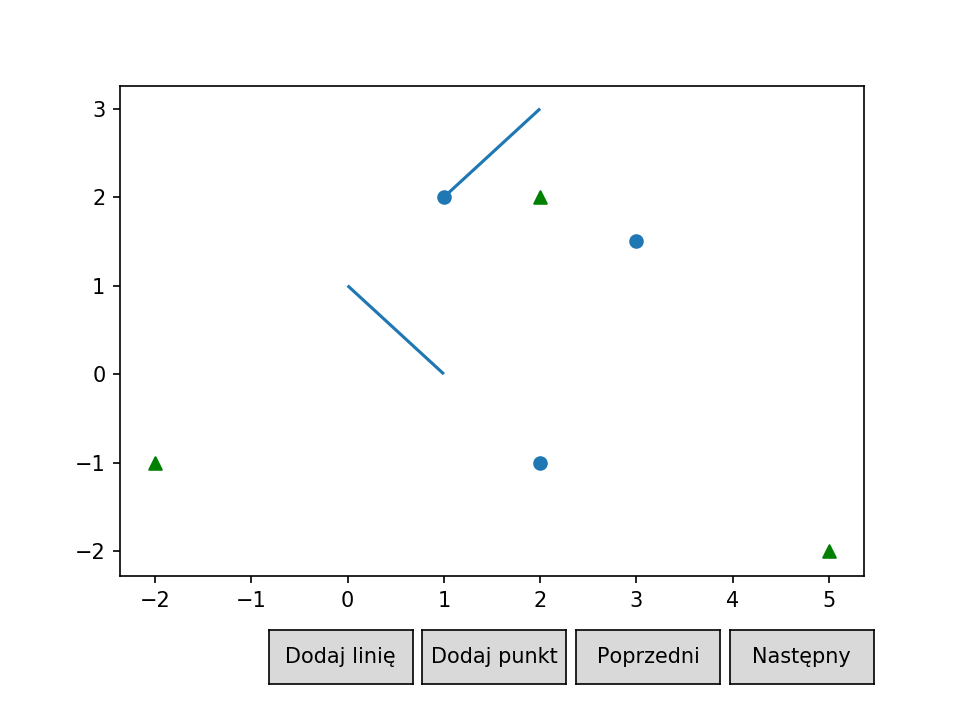

In [9]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red', s=1), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot = Plot(scenes)
plot.add_scene(Scene([PointsCollection([(2, 1)])], [LinesCollection([[(1,2),(2,3)]])]))

plot.draw() 


###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

<IPython.core.display.Javascript object>


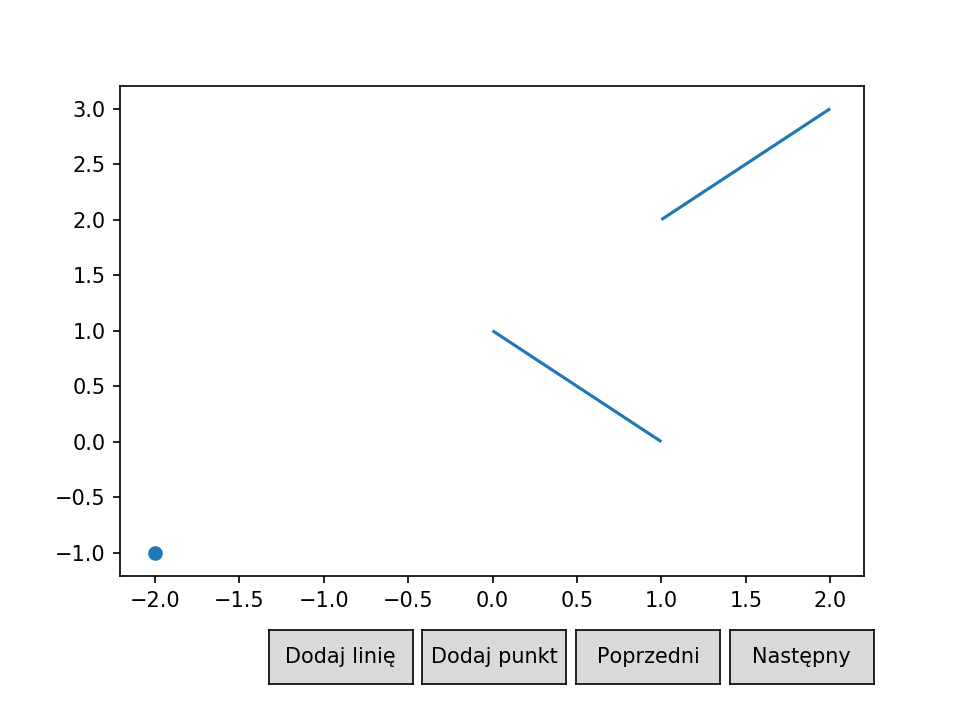

In [10]:
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)

with open('somefile.json', 'w') as file:
    file.write(plot.toJson())
    
#somefile.txt: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
with open('somefile.json', 'r') as file:
    json = file.read()
    
plot2 = Plot(json=json)
plot2.draw()

##### Operowanie na dodanych punktach

Możemy bardzo łatwo rysować nowe punkty i linie. Aby je później wykorzystać sugerowanym sposobem jest utworzenie nowej komórki, w której utworzymy nowy `Plot` i skorzystamy z metod `get_added_points()` i `get_added_points()` lub `get_added_elements()` (zwraca scenę) z pierwszego `Plot`u.

<IPython.core.display.Javascript object>


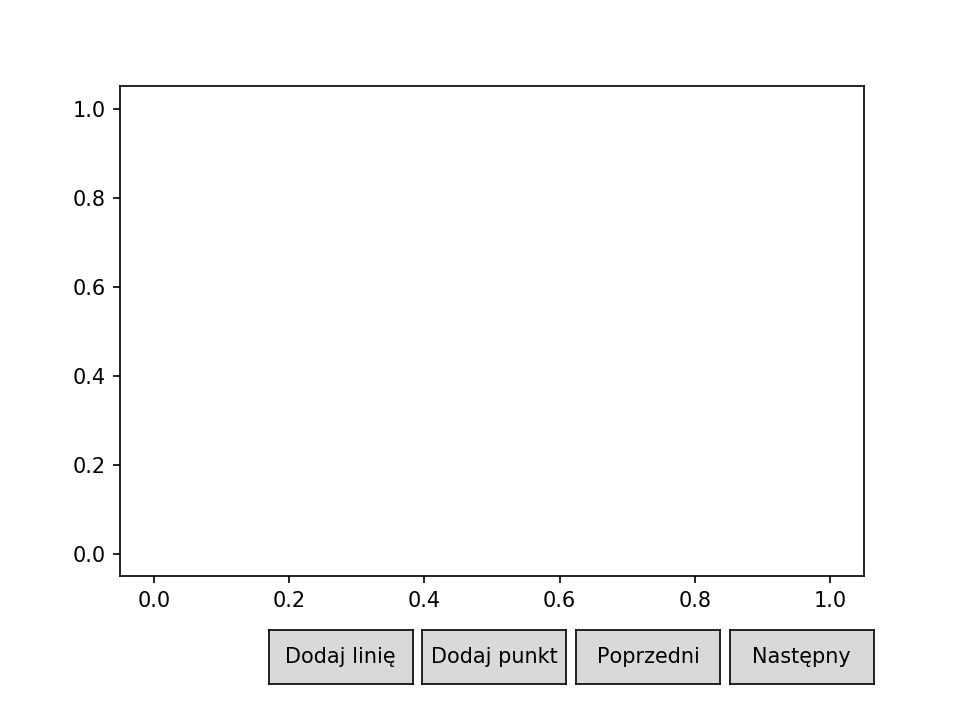

In [11]:
#Dodaj tu punkty i/lub odcinki!
plot1 = Plot()
plot1.draw()

<IPython.core.display.Javascript object>


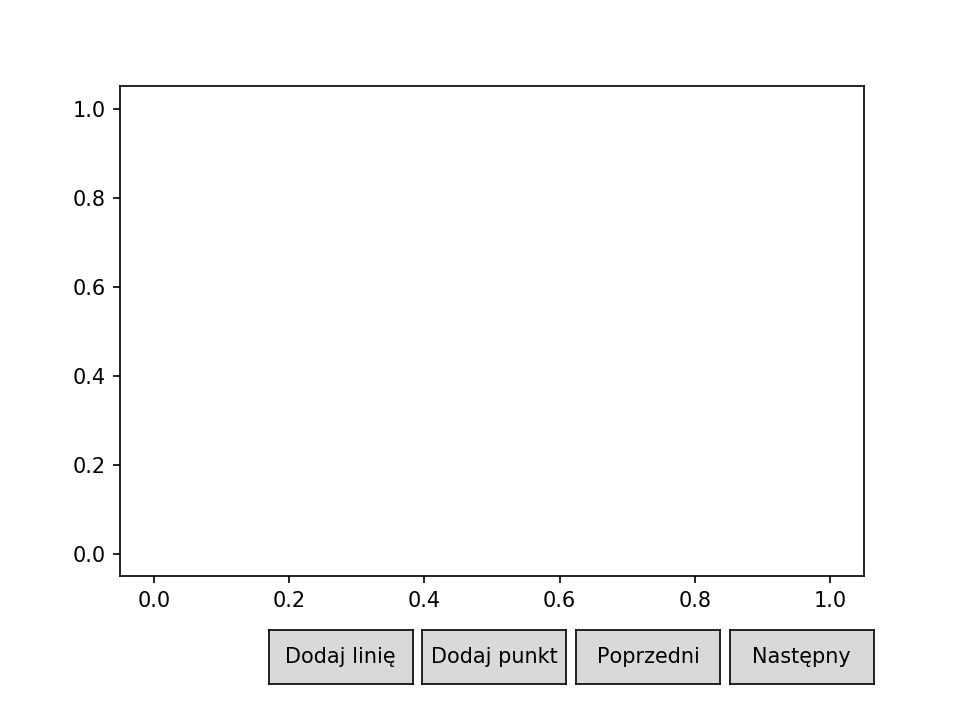

In [12]:
plot2 = Plot([plot1.get_added_elements()])
plot2.draw()

### Rozwiązanie

### Zadanie 1

In [13]:
%matplotlib notebook

epsilon = 10**(-6)

def addSectionTo(sections, point1, point2):
    if point1[1]-point2[1]>epsilon:
        sections.append(createSection(point1, point2))
    return sections
    
    
def createSection(point1, point2):
    return (point1, point2)

    
def generateRandomSections(lowerLeftCorner, upperRightCorner):
    no_points = random.randint(100, 1000)
    sections = []
    points = []
    
    for index in range(no_points):
        point1 = generateRandomPointBetween(lowerLeftCorner, upperRightCorner)
        point2 = generateRandomPointBetween(lowerLeftCorner, upperRightCorner)
        
        while isThereTheSamePoint(points, point1):
            point1 = generateRandomPointBetween(lowerLeftCorner, upperRightCorner)
        while isThereTheSamePoint(points, point2):
            point2 = generateRandomPointBetween(lowerLeftCorner, upperRightCorner)
            
        if point1[1]-point2[1]>epsilon:
            sections.append(createSection(point1, point2))
            points.append(point1)
            points.append(point2)
    
    return sections


def isThereTheSamePoint(sections, point_to_check):
    for section in sections:
        for point in section:
            if point[0]-point_to_check[0]<epsilon and point[1]-point_to_check[1]<epsilon:
                return True

    return False


def generateRandomPointBetween(lowerLeftCorner, upperRightCorner):
    point = (rand.uniform(lowerLeftCorner[0], upperRightCorner[0]), rand.uniform(lowerLeftCorner[1], upperRightCorner[1]))
    return point


### Zadanie 2

In [14]:
%matplotlib notebook

def isThereAnyIntersection(sections):
    events = []
    state = []
    
    addPointsToEventsAndSort(sections, events)
    
    while not isHeapEmpty(events):
        point = heappop(events)
        broom_position = point[0]
        
        for section in sections:
            if section[0][0] == broom_position:
                addToState(state, section)
            if section[1][0] == broom_position and section in state:
                state.remove(section)
        
        for index in range(len(state)-1):
            if doSectionsIntersect(state[index], state[index+1]):
                return True
    
    return False


def addPointsToEventsAndSort(sections, events):
    for section in sections:
        heappush(events, section[0])
        heappush(events, section[1])


def isHeapEmpty(heap):
    return (len(heap) == 0)   #lub heap.count(np.inf)==len(heap)


def addToState(state, section):
    index = 0
    
    while index < len(state) and state[index][0][1] < section[0][1]:
        index += 1
    
    if index == len(state):
        state.append(section)
    else:
        state.insert(index, section) # insert on index


def doSectionsIntersect(section1, section2):
    
    if  pointPosTowardsLine(section1[0], section2) == pointPosTowardsLine(section1[1], section2):
        return False;
    
    if pointPosTowardsLine(section2[0], section1) == pointPosTowardsLine(section2[1], section1):
        return False;
    
    return True;


def pointPosTowardsLine(point, line_points):
    epsilon = 10**(-6)
    base_matrix = [[line_points[0][0], line_points[0][1], 1.0],[line_points[1][0], line_points[1][1], 1.0],[point[0], point[1], 1.0]]
    determinant = np.linalg.det(base_matrix)
        
    if determinant > epsilon:
        return 1
    elif determinant < (-1)*epsilon:
        return -1
    else:
        return 0

# Testy: przechodzą
#sections1 = [[(3, 1), (-2, -1)],[(10, 10), (20, 20)],[(-10, -10), (-20, -20)]]
#sections2 = [[(2, 2), (4, 4)], [(2, 4), (4, 2)]]
#sections3 = [[(1,1), (10,1)], [(5,1), (7,5)]]

#print(sections1)
#print(isThereAnyIntersection(sections1))

#print(sections2)
#print(isThereAnyIntersection(sections2))

#print(sections3)
#print(isThereAnyIntersection(sections3))


### Zadanie 4

### Zadanie 6

In [15]:
# events - kolejka prioretytowa wydarzeń. Punkty odcinków posortowane po współrzędnej x
# state - lista, stan miotły. Odcinki Posortowane po współrzędnej y pierwszego punktu

def sweepingAlgorithm(sections):
    events = []
    state = []
    intersections = []
    intersectingSections = []
    
    addPointsToEventsAndSort(sections, events)
    
    while not isHeapEmpty(events):
        point = heappop(events)
        broom_position = point[0]
        
        for section in sections: #update T
            if section[0][0] == broom_position:
                addToState(state, section)
            if section[1][0] == broom_position and section in state:
                state.remove(section)
        
        if point in intersections:
            index = intersections.index(point)
            [section1, section2] = intersectingSections[index]
            index1 = state.index(section1)
            index2 = state.index(section2)
            state[index1], state[index2] = state[index2], state[index1]
            
        for index in range(len(state)-1): #update Q
            if doSectionsIntersect(state[index], state[index+1]):
                inter = findIntersection(state[index], state[index+1])
                if inter[0] >= broom_position and inter not in intersections:
                    heappush(events, inter)
                    intersections.append(inter)
                    intersectingSections.append([state[index], state[index+1]])

    return (len(intersections), intersections, intersectingSections)


#def swapSectionsIn(state, section1, section2):
#    print(0)


def doSectionsIntersect(section1, section2):
    if pointPosTowardsSection(section1, section2[0]) == pointPosTowardsSection(section1, section2[1]):
        return False
    if pointPosTowardsSection(section2, section1[0]) == pointPosTowardsSection(section2, section1[1]):
        return False
    
    return True


def pointPosTowardsSection(section, point):
    epsilon = 10**(-6)
    
    base_matrix = [[section[0][0], section[0][1], 1],[section[1][0], section[1][1], 1.0],[point[0], point[1], 1.0]]
    determinant = np.linalg.det(base_matrix)
        
    if determinant > epsilon:
        return 1
    elif determinant < (-1)*epsilon:
        return -1
    else:
        return 0
    

def findIntersection(section1, section2):
    vector1 = (section1[1][0]-section1[0][0],section1[1][1]-section1[0][1])
    vector2 = (section2[1][0]-section2[0][0],section2[1][1]-section2[0][1])
    
    A1 = vector1[1]
    B1 = -vector1[0]
    C1 = -section1[0][0]*vector1[1]+section1[0][1]*vector1[0]
    A2 = vector2[1]
    B2 = -vector2[0]
    C2 = -section2[0][0]*vector2[1]+section2[0][1]*vector2[0]
    
    x = -(B2*C1-C2*B1)/(B2*A1-B1*A2)
    y = -(A1*x+C1)/B1
    
    return (x, y)


### Zadanie 8

In [16]:
sections = [[(-10, -10), (-20, -20)], [(2, 2), (4, 4)], [(2, 4), (4, 2)], [(1,1), (10,1)], [(5,1), (7,5)], [(-5, -5), (-1, -1)]]
# sections = [[(0, 0), (5, 0)],[(5, 0), (3, 4)],[(3, 4), (0, 0)], [(0, 2), (5, 2)],[(5, 2), (3, 10)],[(3, 10), (0, 2)]]
(counter, intersections, intersectingSections) = sweepingAlgorithm(sections)

print("Odcinki: ", sections)
print("Ilość przecięć: ", counter)
print("Punkty przecięć: ", intersections)
print("Przecinające się odcinki: ", intersectingSections)

Odcinki:  [[(-10, -10), (-20, -20)], [(2, 2), (4, 4)], [(2, 4), (4, 2)], [(1, 1), (10, 1)], [(5, 1), (7, 5)], [(-5, -5), (-1, -1)]]
Ilość przecięć:  2
Punkty przecięć:  [(3.0, 3.0), (5.0, 1.0)]
Przecinające się odcinki:  [[[(2, 2), (4, 4)], [(2, 4), (4, 2)]], [[(5, 1), (7, 5)], [(1, 1), (10, 1)]]]
